In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas as pd
import warnings
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import trange

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)

In [2]:
train=pd.read_csv('train/train_data.csv')
test=pd.read_csv('test/test_data.csv')
submission= pd.read_csv('sample_submission.csv')


In [7]:
train_file_dir= 'train/'
test_file_dir='test/'
x_train= np.zeros((len(train),28,28,1))
y_train= train['label']
# 데이터 저장할 공간 생성
x_test = np.zeros((len(test), 28,28,1))

for i, image_name in enumerate(train['file_name']):
    x_train[i] = np.reshape(np.array(Image.open(train_file_dir + image_name)),(28,28,1))

for i, image_name in enumerate(test['file_name']):
    x_test[i] = np.reshape(np.array(Image.open(test_file_dir + image_name)), (28,28,1))

In [8]:
# 데이터 분할
from sklearn.model_selection import train_test_split

X_train, X_validation, Y_train, Y_validation = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)


In [9]:
X_train, X_validation, Y_train, Y_validation = train_test_split(x_train, y_train, test_size=0.1, shuffle=True)

In [13]:
# XAI를 수행하기 위해 사전 딥러닝 모델을 학습

from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers

loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model= Sequential([
    layers.Conv2D(32,(3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')

])

model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=20, shuffle =True, validation_data=(X_validation, Y_validation))

model.trainable =False

Epoch 1/20
141/141 [==============================] - 2s 11ms/step - loss: 0.6498 - accuracy: 0.8533 - val_loss: 0.1778 - val_accuracy: 0.9460
Epoch 2/20
141/141 [==============================] - 1s 10ms/step - loss: 0.0877 - accuracy: 0.9711 - val_loss: 0.1368 - val_accuracy: 0.9640
Epoch 3/20
141/141 [==============================] - 1s 10ms/step - loss: 0.0539 - accuracy: 0.9816 - val_loss: 0.1573 - val_accuracy: 0.9620
Epoch 4/20
141/141 [==============================] - 1s 10ms/step - loss: 0.0390 - accuracy: 0.9878 - val_loss: 0.1006 - val_accuracy: 0.9700
Epoch 5/20
141/141 [==============================] - 2s 13ms/step - loss: 0.0304 - accuracy: 0.9900 - val_loss: 0.1100 - val_accuracy: 0.9800
Epoch 6/20
141/141 [==============================] - 2s 14ms/step - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.0902 - val_accuracy: 0.9780
Epoch 7/20
141/141 [==============================] - 2s 16ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.1399 - val_accuracy: 0.9700

In [31]:
import saliency.core as saliency

def model_fn(images, call_model_args, expected_keys=None):
    target_class_idx= call_model_args['class']
    model= call_model_args['model']
    images=tf.convert_to_tensor(images)

    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            output=model(images)
            output=output[:, target_class_idx]
            gradients =np.array(tape.gradient(output, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv, output=model(images)
            gradients =np.array(tape.gradients(output, conv))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv,
            saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [34]:
def vanilla_saliency(model, img):
    pred = model(np.array([img]))
    pred_cls =np.argmax(pred[0])
    args ={'model': model, 'class': pred_cls}

    grad=saliency.GradientSaliency()
    attr =grad.GetMask(img, model_fn, args)
    attr =  saliency.VisualizeImageGrayscale(attr)

    return tf.reshape(attr, (*attr.shape,1))

def ig(model, img):
    pred= model(np.array([img]))
    pred_cls =np.argmax(pred[0])
    args={'model':model, 'class': pred_cls}

    baseline =np.zeros(img.shape)
    ig= saliency.IntegratedGradients()
    attr= ig.GetMask(img, model_fn, args,x_steps=25, x_baseline=baseline, batch_size=20)
    attr =saliency.VisualizeImageGrayscale(attr)

    return tf.reshape(attr, (*attr.shape,1))

def smooth_saliency(model, img):
    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    smooth_grad = saliency.GradientSaliency()
    smooth_attr = smooth_grad.GetSmoothedMask(img, model_fn, args)
    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

def smooth_ig(model, img):

    pred = model(np.array([img]))
    pred_cls = np.argmax(pred[0])
    args = {'model': model, 'class': pred_cls}

    baseline = np.zeros(img.shape)
    smooth_ig = saliency.IntegratedGradients()

    smooth_attr = smooth_ig.GetSmoothedMask(
        img, model_fn, args, x_steps=25, x_baseline=baseline, batch_size=20)

    smooth_attr = saliency.VisualizeImageGrayscale(smooth_attr)

    return tf.reshape(smooth_attr, (*smooth_attr.shape, 1))

In [35]:
data_num =77
sample_image= X_validation[data_num]
sample_saliency_xai_image= vanilla_saliency(model, X_validation[data_num])
sample_ig_xai_image =ig(model, X_validation[data_num])


(-0.5, 27.5, 27.5, -0.5)

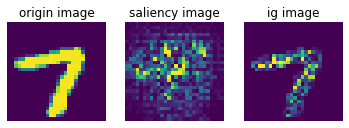

In [36]:
plt.subplot(1, 3, 1)
plt.imshow(np.reshape(sample_image, (28, 28)))
plt.title("origin image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(sample_saliency_xai_image, (28, 28)))
plt.title("saliency image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.reshape(sample_ig_xai_image, (28, 28)))
plt.title("ig image")
plt.axis('off')

In [37]:
ig_x_train = np.zeros_like(x_train)
ig_x_test = np.zeros_like(x_test)

for i in trange(len(ig_x_test)):

    ig_x_train[i] = ig(model, x_train[i])
    ig_x_test[i] = ig(model, x_test[i])
    

100%|██████████| 5000/5000 [04:30<00:00, 18.46it/s]


In [38]:
loss_fn =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

new_model= Sequential([
     layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

new_model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',metrics=['accuracy'])

new_model.fit(ig_x_train, y_train, epochs=20, shuffle=True)

Epoch 1/20
157/157 [==============================] - 2s 13ms/step - loss: 0.6499 - accuracy: 0.8018
Epoch 2/20
157/157 [==============================] - 2s 13ms/step - loss: 0.1432 - accuracy: 0.9552
Epoch 3/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0854 - accuracy: 0.9740
Epoch 4/20
157/157 [==============================] - 2s 11ms/step - loss: 0.0548 - accuracy: 0.9818
Epoch 5/20
157/157 [==============================] - 2s 15ms/step - loss: 0.0315 - accuracy: 0.9900
Epoch 6/20
157/157 [==============================] - 2s 15ms/step - loss: 0.0295 - accuracy: 0.9906
Epoch 7/20
157/157 [==============================] - 2s 15ms/step - loss: 0.0188 - accuracy: 0.9944
Epoch 8/20
157/157 [==============================] - 2s 12ms/step - loss: 0.0120 - accuracy: 0.9960
Epoch 9/20
157/157 [==============================] - 2s 14ms/step - loss: 0.0122 - accuracy: 0.9956
Epoch 10/20
157/157 [==============================] - 2s 15ms/step - loss: 0.0170 - accura

In [40]:
for i in range(len(ig_x_test)):
    data= np.expand_dims(ig_x_test[i],0)
    pred= new_model.predict(data)
    pred = np.argmax([pred])

    submission['label'][i] =int(pred)



In [42]:
submission.to_csv('submission.csv', index= False)

In [ ]:
submission.csv